# Pix2Pix(Image-to-Image Translation with Conditional Adversial Networks) - Tensorflow 2.0

Made by Song GH with Tensorflow 2.0<br>
Paper URL : https://arxiv.org/abs/1611.07004

--------------------------

<img src='./pix2pix paper figure/Figure 1.png'>

# Abastract

- We investigate conditional adversarial networks as a general-purpose solution to image-to-image translation problems.
- These networks not only learn the mapping from input image to output image, but also learn a loss function to train this mapping.
- We demonstrate that this approach is effective at synthesizing photos from label maps, reconstructing  objects from edge maps, and colorizing images, among other tasks.
- we no longer hand-engineer our mapping functions, and this work suggests we can achieve reasonable results without hand-engineering our loss functions either. 

-----------------------------------------------

# 1. Introduction

- 

*****

# 6. Appendix

## 6.1 Network architectures

- Ck denote a Convolution-BatchNorm-ReLU layer with k filters.
- CDk denotes a Convolution-BatchNorm-Dropout-ReLU layer with a dropout rate of 50%.
- All convolutions are 4x4 spatial filters applied with stride 2
- Convolutions in the encoder, and in the discriminator, downsample by a factor of 2, whereas in the decoder they upsample by a factor of 2.

### 6.1.1 Generator architectures

- encoder: C64-C128-C256-C512-C512-C512-C512-C512
- decoder: CD512-CD512-CD512-C512-C256-C128-C64


- After the last layer in the decoder, a convolution is applied to map to the number of output channels (3 in general, except in colorization, where it is 2), followed by a Tanh function.
- As an exception to the above notation, Batch-Norm is not applied to the first C64 layer in the encoder.
- All ReLUs in the encoder are leaky, with slope 0.2, while ReLUs in the decoder are not leaky.
- The U-Net architecture is identical except with skip connections
 - The skip connections concatenate activations from layer i to layer n - i.
 
 
- U-Net decoder: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128

### 6.1.2 Discriminator architectures

- The 70x70 discriminator architecture is: C64-C128-C256-C512
- After the last layer, a convolution is applied to map to a 1-dimensional output, followed by a Sigmoid function.
- BatchNorm is not applied to the first C64 layer.
- All ReLUs are leaky, with slope 0.2.

## 6.2Training details

- Random jitter was applied by resizing the 256x256 input images to 286x286 and then randomly cropping back to size 256 x 256.
- Weights were initialized from a Gaussian distribution with mean 0 and standard deviation 0.02.

### Cityscapes labels->photo
- 2975 training images
- trained for 200 epochs, with random jitter and mirroring.
- we used a batch size of 10
- We find that batch size 1 produces better results for the Unet, but is inappropriate for the encoder-decoder.

### Architectural labels->photo
- 400 training images
- trained for 200 epochs, batch size 1, with random jitter and mirroring.
- Data were split into train and test randomly

### Maps<->aerial photograph
- 1096 training images scraped from Google Maps
- trained for 200 epochs, batch size 1, with random jitter and mirroring
- Data were then split into train and test about the median latitude of the sampling region

### Edges->shoes 
- 50k training images from UT Zappos50K dataset [61] 
- trained for 15 epochs, batch size 4. 
- Data were split into train and test randomly.

### Edges->Handbag 
- 137K Amazon Handbag images from [65], trained for 15 epochs, batch size 4. 
 - [65] : J.-Y. Zhu, P. Kr¨ahenb¨uhl, E. Shechtman, and A. A. Efros. Generative visual manipulation on the natural image manifold. In ECCV, 2016
- Data were split into train and test randomly.


## 6.3 Errata
- For all experiments reported in this paper with batch size 1, the activations of the bottleneck layer are zeroed by the batchnorm operation, effectively making the innermost layer skipped. 
- This issue can be fixed by removing batchnorm from this layer,

## 6.4 Change log
- arXiv v2 Reran generator architecture comparisons (Section 4.3) with batch size equal to 10 rather than 1, so that bottleneck layer is not zeroed

-----------------------------------

## Code Use Method : 

Below you can see <font color='red'>"Dataset & Epoch & batch_size 선택"</font> markdown
```python
dataset_file = dataset[0]
epochs = 200
batch_size = 10
```
check your harddrive enough to download 29M to 8G depending on datasets<br>
you only change number of dataset 0 to 4 <br>
and epoch <br>
and batch_size<br>

-----------------

# Dataset URL :

https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets<br>

0. facades 29M
1. cityscapes 99M
2. maps 239M
3. edges2shoes 2G
4. edges2handbags 8G

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
from IPython import display
import glob
import imageio

2.0.0-alpha0


In [2]:
Jittering_Height = 286
Jittering_Width = 286
Height = 256
Width = 256

In [3]:
data_url = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/'
dataset = ['facades.tar.gz', 'cityscapes.tar.gz','maps.tar.gz','edges2shoes.tar.gz','edges2handbags.tar.gz']

## Dataset & Epoch & batch_size 선택

- dataset[0] = facades
- dataset[1] = cityscapes
- dataset[2] = maps
- dataset[3] = edges2shoes
- dataset[4] = edges2handbags

In [4]:
dataset_file = dataset[2]
epochs = 200
batch_size = 10

In [5]:
dataset_name = dataset_file.split('.')[0]
print(dataset_name)

maps


In [6]:
get_file = tf.keras.utils.get_file(dataset_file,
                                   origin = data_url + dataset_file,
                                   extract=True)

print(get_file)
dataset_link = os.path.dirname(get_file) + '\\' + dataset_name + '/'
print(dataset_link)

C:\Users\la\.keras\datasets\maps.tar.gz
C:\Users\la\.keras\datasets\maps/


### dataset_train_image 관찰

(600, 1200, 3)
255 0
(256, 512, 3)
255.0 0.9868164


(-0.5, 511.5, 255.5, -0.5)

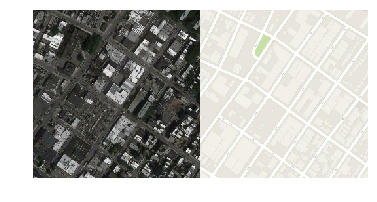

In [7]:
train_sample_image = tf.io.read_file(dataset_link + 'train/10.jpg')
train_sample_image = tf.io.decode_jpeg(train_sample_image)
print(train_sample_image.shape)
print(np.max(train_sample_image), np.min(train_sample_image))

if train_sample_image.shape[0] != Height: # Height=256
    train_sample_image = tf.image.resize(train_sample_image, [Height, Width*2]) 
    print(train_sample_image.shape)
    print(np.max(train_sample_image), np.min(train_sample_image))
    
plt.figure()
plt.imshow(train_sample_image/255.)
plt.axis('off')

255.0 157.97192
254.24756 0.9868164


(-0.5, 255.5, 255.5, -0.5)

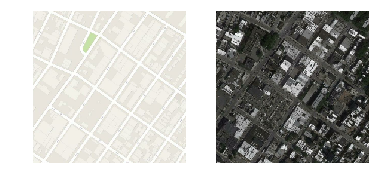

In [8]:
inputs_sample = train_sample_image[:, Width:,:]
ground_truth_sample = train_sample_image[:, :Width,:]
inputs_sample = tf.cast(inputs_sample, tf.float32)
ground_truth_sample = tf.cast(ground_truth_sample, tf.float32)
print(np.max(inputs_sample), np.min(inputs_sample))
print(np.max(ground_truth_sample), np.min(ground_truth_sample))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(inputs_sample/255.)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ground_truth_sample/255.)
plt.axis('off')

### dataset 개수 확인

In [9]:
train_num = glob.glob(dataset_link+'train/*.jpg')
val_num = glob.glob(dataset_link+'val/*.jpg')
test_num = glob.glob(dataset_link+'test/*.jpg')
print(len(train_num))
print(len(val_num))
print(len(test_num))

1096
1098
0


### Image Preprocessing random_jittering & random mirroring

In [10]:
def random_jitter_and_mirroring(image_abs_path):
    image = tf.io.read_file(image_abs_path)
    image = tf.io.decode_jpeg(image) 
    # type <class 'tensorflow.python.framework.ops.EagerTensor'>
    # shape (none,none,none)
    
    height = tf.shape(image)[0]
    width = tf.shape(image)[1] // 2
    # resize 256 -> 286 wrote in paper 6.2 first paragraph
    
    inputs, ground_truth = image[:, width:,:], image[:,:width,:]
    
    inputs = tf.cast(inputs, tf.float32)
    ground_truth = tf.cast(ground_truth, tf.float32)
    
    inputs = tf.image.resize(inputs, [Jittering_Height, Jittering_Width]) #ValueError: 'images' contains no shape.
    ground_truth = tf.image.resize(ground_truth, [Jittering_Height, Jittering_Width])
    
    # randomly cropping back from 286 to 256
    # for smae crop in inputs and ground_truth use stack
    
    # cf) tf.expand_dims(inputs, axis=0)의 방식으로 쌓는 방식도 있음
    
    stack = tf.stack([inputs, ground_truth]) # axis=0 default
    random_crop = tf.image.random_crop(stack, size=[2, Height, Width, 3])
    inputs, ground_truth = random_crop[0], random_crop[1]
    
    # for random_mirroring
    """
    random_crop = tf.image.random_crop(stack, size=[2, Height, Width, 3])
    inputs, ground_truth = tf.image.random_flip_left_right(random_crop)
    
    tf.image.random_flip_left_right를 사용할려고 stack 형식의 image를 바로 넣어봤지만
    inputs이 filp이 될 때 ground_truth 값이 flip 되지 않을 때가 존재한다는 점을 알게되었고
    이는 학습에 있어서 매우 중요한 label과의 부정확한 일치성때문에
    새롭게 random 함수를 통한 flip을 같이 이뤄질 수 있게 해야만 했다.
    """
    
    # 0 or 1이 나오도록 설정한 후 1이 나오면 flip
    if tf.random.uniform([1], minval=0, maxval=2, dtype=tf.dtypes.int32) == 1:
        inputs = tf.image.flip_left_right(inputs)
        ground_truth = tf.image.flip_left_right(ground_truth)
        
    return inputs, ground_truth

## 참조 : 
urllib, tarfile, cv2를 이용해서 만들수도 있다.
```python

from urllib.request import urlretrieve
import tarfile

url = data_url+dataset_file
a= urlretrieve(url, dataset_file)

tar = tarfile.open(dataset_file)
tar.extractall()
tar.close()

dataset_link = './'+dataset_name+'/'
print(dataset_link)
```

### cf) 
``` python
def random_jitter_and_mirroring(image_abs_path):
    image = cv2.imread(image_abs_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    width = image.shape[1] // 2
    
    inputs, ground_truth = image[:, width:,:], image[:,:width,:]  
    
    inputs = cv2.resize(inputs, (286, 286))
    ground_truth = cv2.resize(ground_truth, (286, 286))
    
    inputs = inputs.astype('float32')
    ground_truth = ground_truth.astype('float32')
    
    stack = tf.stack([inputs, ground_truth]) 
    random_crop = tf.image.random_crop(stack, size=[2, Height, Width, 3])
    inputs, ground_truth = random_crop[0], random_crop[1]
    
    if tf.random.uniform([1], minval=0, maxval=2, dtype=tf.dtypes.int32) == 1:
        inputs = cv2.flip(inputs,1) # 1 좌우, 0 상하 반전
        ground_truth = cv2.flip(ground_truth,1)    
    
    return inputs, ground_truth
```
이런 방식의 사용은 Error를 불러일으킨다. 특히나 type 문제에 있어 고질적인 문제를 일으키는데 그것이 일반적인 절대경로의 img라면 상관없지만 tf.data.Dataset files를 mapping 하는데 문제가 생긴다. 따라서 최대한 tensorflow api 기준으로 만드는 것이 가장 안전하면서 빠른 방법이고 최적이다. 
만약 cv2를 이용해서 함수를 만들고자 한다면 cv2로만의 함수로 만들어야한다. 

### Preprocessing 시행 결과 확인하기

(256, 256, 3) (256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

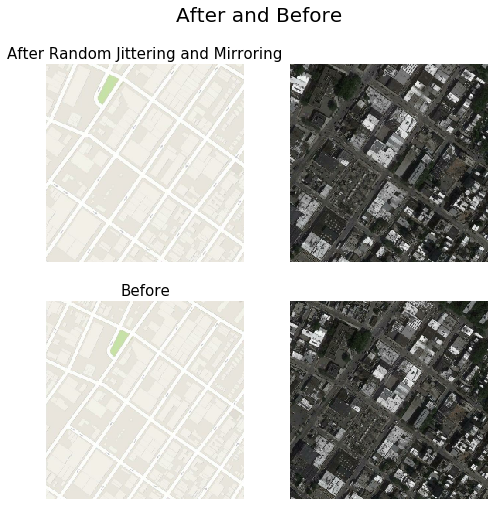

In [11]:
a,b=random_jitter_and_mirroring(dataset_link + 'train/10.jpg')
print(a.shape, b.shape)

plt.figure(figsize=(8,8))
plt.suptitle('After and Before', fontsize=20)

plt.subplot(2,2,1).set_title('After Random Jittering and Mirroring', fontsize=15)
plt.imshow(a/255.)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(b/255.)
plt.axis('off')
plt.subplot(2,2,3).set_title('Before', fontsize=15)
plt.imshow(inputs_sample/255.)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(ground_truth_sample/255.)
plt.axis('off')

### Normalize 함수로 [-1,1] 범위 만들기

In [12]:
def normalize(inputs, ground_truth):
    #tanh activation => need to normalize [-1,1]
    inputs = (inputs / 127.5 ) - 1
    ground_truth = (ground_truth / 127.5) - 1
    return inputs, ground_truth
"""
def normalize(inputs, ground_truth):
    #tanh activation => need to normalize [-1,1]
    inputs = (inputs - 127.5 ) / 127.5
    ground_truth = (ground_truth - 127.5) / 127.5
    return inputs, ground_truth
"""

'\ndef normalize(inputs, ground_truth):\n    #tanh activation => need to normalize [-1,1]\n    inputs = (inputs - 127.5 ) / 127.5\n    ground_truth = (ground_truth - 127.5) / 127.5\n    return inputs, ground_truth\n'

In [13]:
def test_load_resize_normalize(image_abs_path):
    image = tf.io.read_file(image_abs_path)
    image = tf.io.decode_jpeg(image)
    
    height = tf.shape(image)[0]
    width = tf.shape(image)[1] // 2
    
    # resize 256 -> 286 wrote in paper 6.2 first paragraph
    
    inputs, ground_truth = image[:, width:,:], image[:,:width,:]
    
    inputs = tf.cast(inputs, tf.float32)
    ground_truth = tf.cast(ground_truth, tf.float32)
    
    if height != Height:
        inputs = tf.image.resize(inputs, [Height, Width])
        ground_truth = tf.image.resize(ground_truth, [Height, Width])
    
    #tanh activation => need to normalize [-1,1]
    inputs = (inputs / 127.5 ) - 1
    ground_truth = (ground_truth / 127.5) - 1
    return inputs, ground_truth

### train, test dataset 뭉치기

In [14]:
train_buffer_size = len(glob.glob(dataset_link+'train/*.jpg'))
train_dataset = tf.data.Dataset.list_files(dataset_link + 'train/*.jpg').shuffle(train_buffer_size)
if not dataset_name in ['edges2shoes','edges2handbags']:
    train_dataset = train_dataset.map(random_jitter_and_mirroring)
train_dataset = train_dataset.map(normalize).batch(batch_size)

In [15]:
if dataset_name == 'facades':
    test_buffer_size = len(glob.glob(dataset_link+'test/*.jpg'))
    test_dataset = tf.data.Dataset.list_files(dataset_link + 'test/*.jpg').shuffle(test_buffer_size)
    test_dataset = test_dataset.map(test_load_resize_normalize).batch(batch_size)    
else:
    test_buffer_size = len(glob.glob(dataset_link+'val/*.jpg'))
    test_dataset = tf.data.Dataset.list_files(dataset_link + 'val/*.jpg').shuffle(test_buffer_size)
    test_dataset = test_dataset.map(test_load_resize_normalize).batch(batch_size)

- Ck denote a Convolution-BatchNorm-ReLU layer with k filters.
- CDk denotes a Convolution-BatchNorm-Dropout-ReLU layer with a dropout rate of 50%.
- All convolutions are 4x4 spatial filters applied with stride 2
- Convolutions in the encoder, and in the discriminator, downsample by a factor of 2, whereas in the decoder they upsample by a factor of 2.
- encoder: C64-C128-C256-C512-C512-C512-C512-C512
- decoder: CD512-CD512-CD512-C512-C256-C128-C64

downsample : encoder

upsample : decoder

In [16]:
class downsample(tf.keras.Model):
    def __init__(self, filters, apply_batchnorm=True):
        super(downsample, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=2, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(0.,0.02))
        self.apply_batchnorm = apply_batchnorm
        
        if apply_batchnorm:
            self.batchnorm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha=0.2)
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        if self.apply_batchnorm:
            x = self.batchnorm(x, training=training)
        x = self.activation(x)
        return x    

In [17]:
inputs_sample.shape

TensorShape([256, 256, 3])

In [18]:
down = downsample(3, apply_batchnorm=True)
down = down(tf.expand_dims(tf.cast(inputs_sample, tf.float32),0))
print(down.shape)

(1, 128, 128, 3)


In [19]:
class upsample(tf.keras.Model):
    def __init__(self, filters, apply_dropout=False):
        super(upsample, self).__init__()
        self.conv = tf.keras.layers.Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same',
                                                    kernel_initializer=tf.random_normal_initializer(0.,0.02))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        
        self.apply_dropout = apply_dropout
        if apply_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.activation = tf.keras.layers.ReLU()
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.batchnorm(x, training=training)
        if self.apply_dropout:
            x = self.dropout(x, training=training)
        x = self.activation(x)
        return x    

In [20]:
up = upsample(3, apply_dropout=True)
up = up(down)
print(up.shape)

(1, 256, 256, 3)


In [21]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.down1 = downsample(filters=64, apply_batchnorm=False)
        self.down2 = downsample(128)
        self.down3 = downsample(256)
        self.down4 = downsample(512)
        self.down5 = downsample(512)
        self.down6 = downsample(512)
        self.down7 = downsample(512)
        self.down8 = downsample(512)
        
        self.up1 = upsample(filters=512, apply_dropout=True)
        self.up2 = upsample(filters=512, apply_dropout=True)
        self.up3 = upsample(filters=512, apply_dropout=True)
        self.up4 = upsample(filters=512)
        self.up5 = upsample(filters=256)
        self.up6 = upsample(filters=128)
        self.up7 = upsample(filters=64)
        
        self.last_conv = tf.keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same',
                                                kernel_initializer=tf.random_normal_initializer(0.,0.02),
                                                activation=tf.keras.activations.tanh)
        
    def call(self, inputs, training=True):
        
        down1 = self.down1(inputs) #[256,256,3] -> [128,128,64]
        down2 = self.down2(down1) #[128,128,64] -> [64,64,128]
        down3 = self.down3(down2) # [64,64,128] -> [32,32,256]
        down4 = self.down4(down3) # [32,32,256] -> [16,16,512]
        down5 = self.down5(down4) # [16,16,512] -> [8,8,512]
        down6 = self.down6(down5) #   [8,8,512] -> [4,4,512]
        down7 = self.down7(down6) #   [4,4,512] -> [2,2,512]
        down8 = self.down8(down7) #   [2,2,512] -> [1,1,512]
        
        up1 = self.up1(down8) # [1,1,512] -> [2,2,512]
        up1 = tf.keras.layers.concatenate([up1, down7]) # [2,2,1024]
        #print('up1.shape:',up1.shape)
        up2 = self.up2(up1) # [2,2,1024] -> [4,4,512]        
        up2 = tf.keras.layers.concatenate([up2, down6]) # [4,4,1024]
        #print('up2.shape:',up2.shape)
        up3 = self.up3(up2) # [4,4,1024] -> [8,8,512]
        up3 = tf.keras.layers.concatenate([up3, down5]) # [8,8,1024]
        #print('up3.shape:',up3.shape)
        up4 = self.up4(up3) # [8,8,512] -> [16,16,512]
        up4 = tf.keras.layers.concatenate([up4, down4]) # [16,16,1024]
        #print('up4.shape:',up4.shape)
        up5 = self.up5(up4) # [16,16,512] -> [32,32,256]
        up5 = tf.keras.layers.concatenate([up5, down3]) # [32,32,512]
        #print('up5.shape:',up5.shape)
        up6 = self.up6(up5) # [32,32,256] -> [64,64,128]
        up6 = tf.keras.layers.concatenate([up6, down2]) # [64,64,256]
        #print('up6.shape:',up6.shape)
        up7 = self.up7(up6) # [64,64,128] -> [128,128,64]
        up7 = tf.keras.layers.concatenate([up7, down1]) # [128,128,128]
        #print('up7.shape:',up7.shape)
        
        last = self.last_conv(up7) # [128,128,64] -> [256,256,3]
        #print('last',last.shape)
        return last    

In [22]:
print(np.max(inputs_sample), np.min(inputs_sample),np.max(ground_truth_sample), np.min(ground_truth_sample))
inputs_sample, ground_truth_sample = normalize(inputs_sample, ground_truth_sample)
print(np.max(inputs_sample), np.min(inputs_sample),np.max(ground_truth_sample), np.min(ground_truth_sample))

255.0 157.97192 254.24756 0.9868164
1.0 0.23899543 0.99409854 -0.9922603


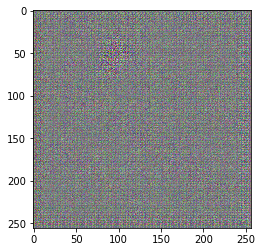

In [23]:
generator = Generator()
output = generator(tf.expand_dims(inputs_sample,0), training=False)
output = output * 0.5 + 0.5 # [1,-1] -> [1, 0]
plt.figure()
plt.imshow(tf.squeeze(output))

In [24]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.down1 = downsample(filters=64, apply_batchnorm=False)
        self.down2 = downsample(128)
        self.down3 = downsample(256)
        
        self.pad1 = tf.keras.layers.ZeroPadding2D()
        self.conv1 = tf.keras.layers.Conv2D(filters=512, kernel_size=4, strides=1,
                                           padding='valid',
                                           kernel_initializer=tf.random_normal_initializer(0., 0.02))
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.leaky1 = tf.keras.layers.LeakyReLU(alpha=0.2)
        
        self.pad2 = tf.keras.layers.ZeroPadding2D()
        self.conv2 = tf.keras.layers.Conv2D(filters=1, kernel_size=4, strides=1,
                                           padding='valid',
                                           kernel_initializer=tf.random_normal_initializer(0., 0.02))
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        
        
    def call(self, inputs, unknown, training=True):
        #tf.concat([], axis=-1) 사용도 가능
        x = tf.keras.layers.concatenate([inputs, unknown]) #default axis=-1 # [256,256,3+3]
        x = self.down1(x) # [256,256,6] => [128,128,64]
        x = self.down2(x) # [128,128,64] => [64,64,128]
        x = self.down3(x) # [64,64,128] => [32,32,256]       
        
        x = self.pad1(x) # (1, 34, 34, 256)
        x = self.conv1(x) # (1, 31, 31, 512)
        x = self.batchnorm1(x)
        x = self.leaky1(x)
        
        x = self.pad2(x) # (1, 33, 33, 512)
        x = self.conv2(x) # (1, 30, 30, 1)
        x = self.batchnorm2(x)
        
        return x

(1, 30, 30, 1)


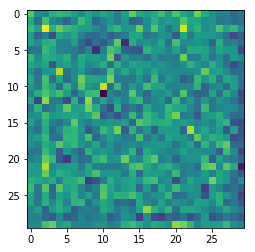

In [25]:
discriminator = Discriminator()
disc_output = discriminator(tf.expand_dims(inputs_sample,0),output)
print(disc_output.shape)
plt.imshow(disc_output[0,:,:,0])

In [26]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def generator_loss(disc_gen, gen_output, ground_truth):
    loss_c = loss(tf.ones_like(disc_gen), disc_gen) # 1x1    
    l1_loss = tf.keras.losses.MAE(ground_truth, gen_output) # 256x256
    tot_gen_loss = loss_c + 100*l1_loss # 256x256    
    return tot_gen_loss

In [28]:
def discriminator_loss(disc_real, disc_gen):
    loss_real = loss(tf.ones_like(disc_real),disc_real) #1x1
    loss_gen = loss(tf.zeros_like(disc_gen), disc_gen) #1x1    
    tot_disc_loss = loss_real + loss_gen    #1x1
    return tot_disc_loss

In [29]:
#  defalut learning_rate=0.001,beta_1=0.9,beta_2=0.999, epsilon=1e-07,
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999) 
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

In [30]:
generator = Generator()
discriminator = Discriminator()

In [31]:
@tf.function
def train_step(inputs, ground_truth):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(inputs, training=True)
        
        disc_real = discriminator(inputs, ground_truth, training=True)
        disc_gen = discriminator(inputs, gen_output, training=True)
        
        gen_loss = generator_loss(disc_gen, gen_output, ground_truth) # 256x256
        disc_loss = discriminator_loss(disc_real, disc_gen) # 1x1
        
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))   
    
    return gen_loss, disc_loss

In [32]:
if not os.path.isdir('./pix2pix_'+dataset_name):
    os.makedirs('./pix2pix_'+dataset_name)

In [33]:
def save_images(generator, inputs, ground_truth, epoch=0):
        
    gen_output = generator(inputs, training=True)
    fig = plt.figure(figsize=(15,15))
    fig.suptitle('Epoch:{:03d}'.format(epoch), fontsize=30)
    name = ['Inputs','Ground_Truth', 'Gen_Output','Inputs','Ground_Truth', 'Gen_Output']
    display = [inputs[0], ground_truth[0], gen_output[0],inputs[1], ground_truth[1], gen_output[1]]    
    
    for i in range(3):
        plt.subplot(2,3,i+1)
        plt.imshow(display[i]*0.5 + 0.5)
        plt.title(name[i])
        plt.axis('off')
        plt.subplot(2,3,i+4)
        plt.imshow(display[i+3]*0.5 + 0.5)
        plt.title(name[i])
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig('./pix2pix_'+dataset_name+'/'+dataset_name+'_epoch_{:03d}.png'.format(epoch))
    plt.show()

(10, 256, 256, 3) (10, 256, 256, 3)


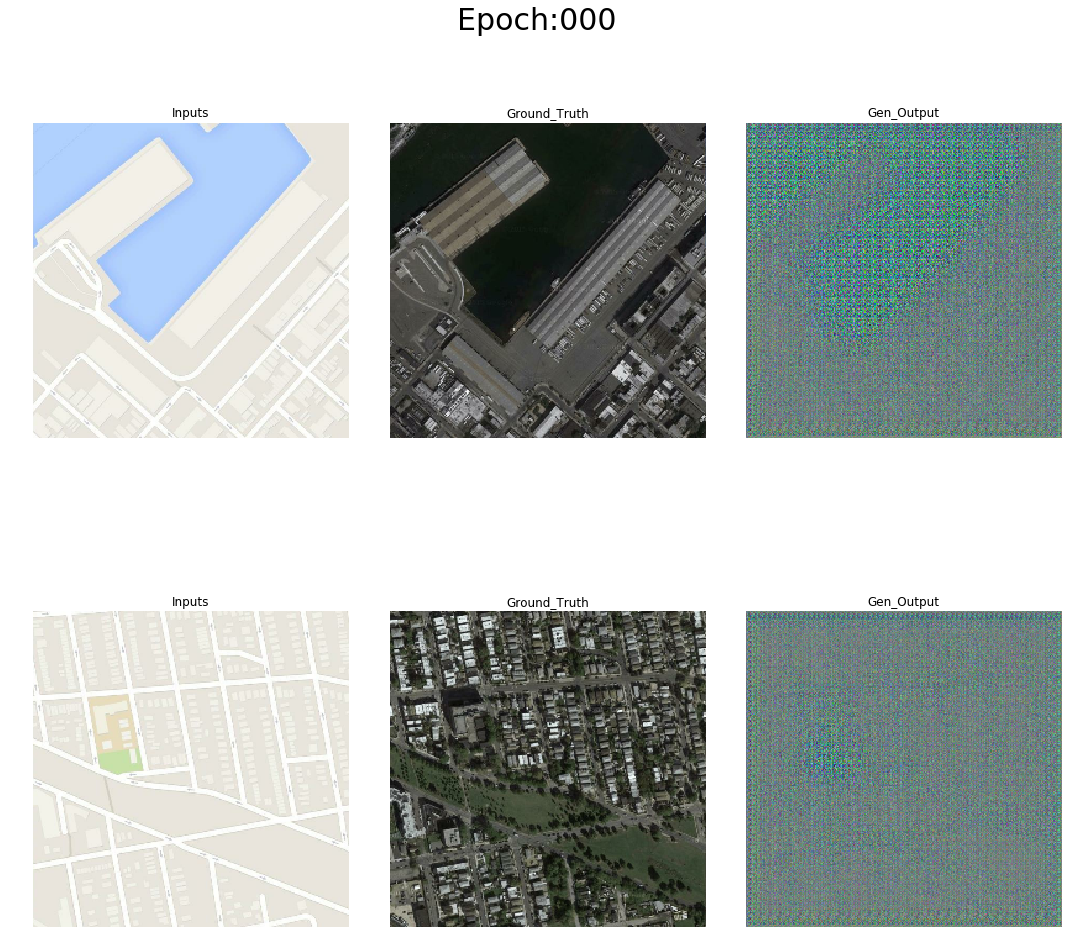

In [34]:
for inputs, ground_truth in test_dataset.take(1):
    print(inputs.shape, ground_truth.shape)
    save_images(generator,inputs, ground_truth)

In [35]:
checkpoint_dir = './training_'+dataset_name+'_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminaotr_optimizer = discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

# Train

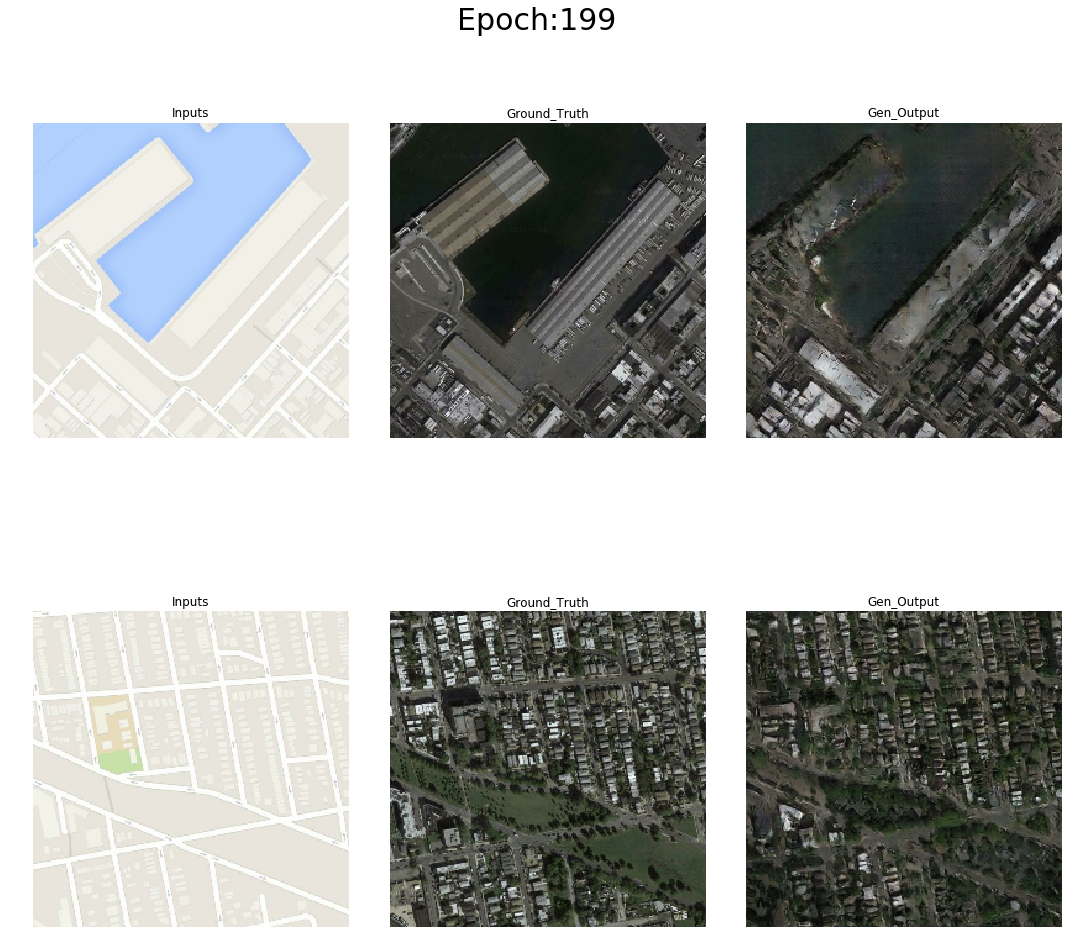

epoch : 199, 36.203 sec


In [36]:
#gen_loss = []
disc_loss =[]
time_ch = []

for epoch in range(epochs):
    start = time.time()
    
    for inputs, ground_truth in train_dataset:
        get_gen_loss, get_disc_loss = train_step(inputs, ground_truth)
        #gen_loss.append(get_gen_loss.numpy())
        disc_loss.append(np.sum(get_disc_loss.numpy()))
    
    end = time.time()
    time_ch.append(end-start)
    
    display.clear_output(wait=True)
    for inputs, ground_truth in test_dataset.take(1):
        save_images(generator, inputs, ground_truth, epoch)
    
    if epoch % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        
    print('epoch : {:03d}, {:02.3f} sec'.format(epoch, end - start))

In [37]:
np.mean(disc_loss)

1.0520067

batch_size(10) * (len(disc_loss) or len(gen_loss))(40) = train_num = 400

In [40]:
print(len(disc_loss))
#print(len(gen_loss))

22000


In [45]:
print(min(disc_loss), max(disc_loss))

0.103023715 3.9602268


In [43]:
disc_loss[-10:]

[1.0968847,
 0.66690254,
 0.8308389,
 1.2187665,
 1.6319094,
 0.8201504,
 0.9466205,
 1.5057132,
 1.2518212,
 0.88351446]

In [46]:
print(glob.glob('./pix2pix_'+dataset_name+'/'+dataset_name+'_epoch*.png')[:5])

['./pix2pix_maps\\maps_epoch_000.png', './pix2pix_maps\\maps_epoch_001.png', './pix2pix_maps\\maps_epoch_002.png', './pix2pix_maps\\maps_epoch_003.png', './pix2pix_maps\\maps_epoch_004.png']


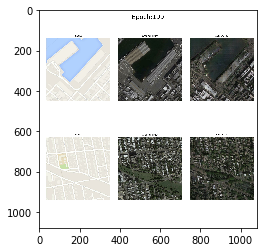

In [47]:
with imageio.get_writer('pix2pix_'+dataset_name+'.gif', mode='I', duration=0.2) as writer:
    file_list = sorted(glob.glob('./pix2pix_'+dataset_name+'/'+dataset_name+'_epoch*.png'))
    
    for i, image_file in enumerate(file_list):
        image = imageio.imread(image_file)
        plt.imshow(image)
        writer.append_data(image)